In [1]:
import zipfile
import os
import pandas as pd

In [12]:
def concatenar_csvs(diretorio):
    frames = []

    for arquivo in os.listdir(diretorio):
        if arquivo.endswith('.csv'):
            caminho_arquivo = os.path.join(diretorio, arquivo)
            
            df = pd.read_csv(caminho_arquivo, encoding='utf-8', delimiter=";", decimal=",")
            df = df.rename(columns={df.columns[0]: "data_base"})
            df['data_base'] = pd.to_datetime(df['data_base'], format="%Y-%m-%d")
            df['mes'] = df['data_base'].dt.month #cria uma nova coluna com mês
            df['ano'] = df['data_base'].dt.year
            #Filtros:
            df = df[df['cliente'] == 'PF'] #trocar para o ano que você quer filtrar
            df['porte'] = df['porte'].str.replace(' ','')
#           filtro1 = df['porte'] == "PJ-Micro"
#           filtro2 = df['porte'] == "PJ-Pequeno"
#           df = df.loc[filtro1 | filtro2]
            df = df[['a_vencer_de_1081_ate_1800_dias','data_base', 'modalidade', 'porte', 'numero_de_operacoes', 'a_vencer_de_361_ate_1080_dias', 
  'a_vencer_de_1801_ate_5400_dias', 'a_vencer_acima_de_5400_dias']]
            df['numero_de_operacoes'] = df['numero_de_operacoes'].astype(str)
            df = df[df['numero_de_operacoes'] != '<= 15']
            #Nova coluna para endividamento de LONGO prazo
            df['longo_prazo'] = df['a_vencer_de_361_ate_1080_dias'] + df['a_vencer_de_1081_ate_1800_dias'] + df['a_vencer_de_1801_ate_5400_dias'] + df['a_vencer_acima_de_5400_dias']
            df = df.drop(columns = ['a_vencer_de_361_ate_1080_dias', 'a_vencer_de_1081_ate_1800_dias', 'a_vencer_de_1801_ate_5400_dias', 'a_vencer_acima_de_5400_dias'], axis = 1)
            #Agrupamentos para análise
  #         df = df.groupby(['data_base','modalidade','porte'])['longo_prazo'].sum().reset_index()
            
            frames.append(df)

    df_concatenado = pd.concat(frames, ignore_index=True)

    return df_concatenado

,data_base,modalidade,porte,numero_de_operacoes,longo_prazo
0,2012-06-30,PF - Cartão de crédito,PF-Acimade20saláriosmínimos,31,1203.94
1,2012-06-30,PF - Cartão de crédito,PF-Acimade20saláriosmínimos,1746,2911.48
2,2012-06-30,PF - Empréstimo com consignação em folha,PF-Acimade20saláriosmínimos,919,12071210.71
3,2012-06-30,PF - Empréstimo sem consignação em folha,PF-Acimade20saláriosmínimos,508,2605089.51
4,2012-06-30,PF - Habitacional,PF-Acimade20saláriosmínimos,26,655963.61
...,...,...,...,...,...
198465,2012-12-31,PF - Empréstimo sem consignação em folha,PF-Maisde2a3saláriosmínimos,273,74.93
198466,2012-12-31,PF - Cartão de crédito,PF-Maisde3a5saláriosmínimos,1135,0.00
198467,2012-12-31,PF - Empréstimo sem consignação em folha,PF-Maisde3a5saláriosmínimos,388,640.92
198468,2012-12-31,PF - Cartão de crédito,PF-Maisde5a10saláriosmínimos,733,2010.83


In [15]:
anos = list(range(2012, 2024))
dataframes = []

for ano in anos:
    diretorio = f"planilha_{ano}"
    dataframe_ano = concatenar_csvs(diretorio)
    dataframes.append(dataframe_ano)

df_total = pd.concat(dataframes, ignore_index=False)

In [16]:
df_total['data_base'] = pd.to_datetime(df_total['data_base'])

In [18]:
df_total.to_csv("analise_pf_longoprazo_numero_operacoes.csv")
df_total.head()

,data_base,modalidade,porte,numero_de_operacoes,longo_prazo
0,2012-06-30,PF - Cartão de crédito,PF-Acimade20saláriosmínimos,31,1203.94
1,2012-06-30,PF - Cartão de crédito,PF-Acimade20saláriosmínimos,1746,2911.48
2,2012-06-30,PF - Empréstimo com consignação em folha,PF-Acimade20saláriosmínimos,919,12071210.71
3,2012-06-30,PF - Empréstimo sem consignação em folha,PF-Acimade20saláriosmínimos,508,2605089.51
4,2012-06-30,PF - Habitacional,PF-Acimade20saláriosmínimos,26,655963.61


In [29]:
df_total['numero_de_operacoes'] = df_total['numero_de_operacoes'].astype(int)

In [30]:
df_total['longo_prazo'] = df_total['longo_prazo'].astype(float)

In [32]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6325878 entries, 0 to 589511
Data columns (total 5 columns):
 #   Column               Dtype         
---  ------               -----         
 0   data_base            datetime64[ns]
 1   modalidade           object        
 2   porte                object        
 3   numero_de_operacoes  int32         
 4   longo_prazo          float64       
dtypes: datetime64[ns](1), float64(1), int32(1), object(2)
memory usage: 265.4+ MB


In [46]:
df_agrupado_noperacoes = df_total.groupby(['data_base','modalidade'])['numero_de_operacoes'].sum().reset_index()


In [47]:
df_agrupado_noperacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   data_base            945 non-null    object
 1   modalidade           945 non-null    object
 2   numero_de_operacoes  945 non-null    int32 
dtypes: int32(1), object(2)
memory usage: 18.6+ KB


In [48]:
df_agrupado_noperacoes['data_base'] = pd.to_datetime(df_agrupado_noperacoes['data_base'])

In [44]:
df_agrupado_noperacoes['data_base'] = df_agrupado_noperacoes['data_base'].dt.strftime('%Y-%m')

In [ ]:
import plotly.express as px

C:\Users\USER\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



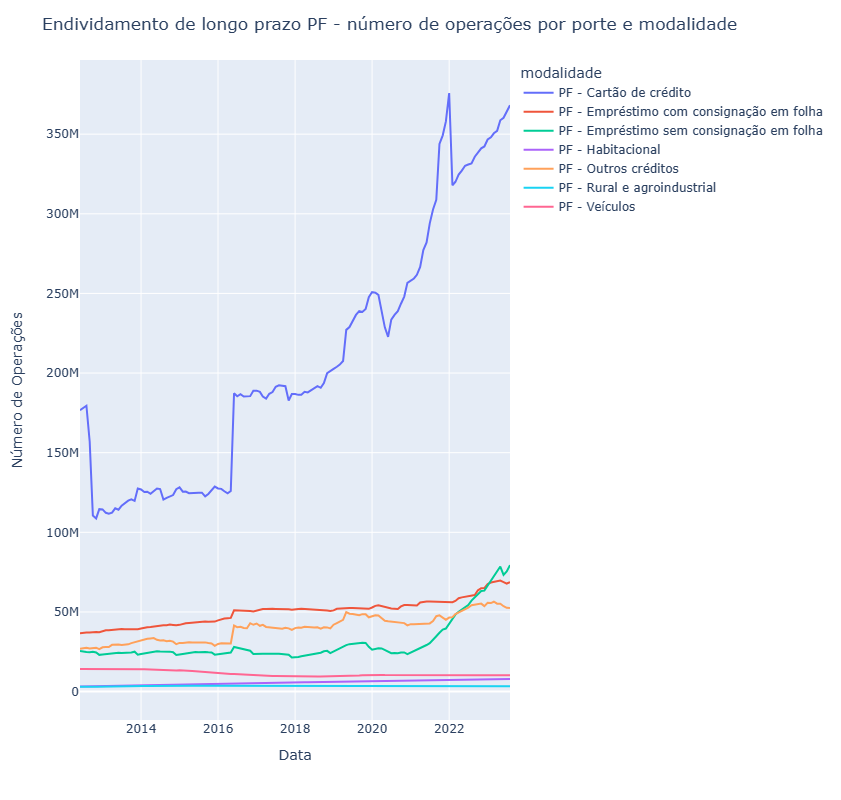

In [49]:
fig = px.line(df_agrupado_noperacoes, 
             x='data_base',
             y='numero_de_operacoes', 
             color='modalidade')

fig.update_layout(title_text='Endividamento de longo prazo PF - número de operações por porte e modalidade',
             xaxis_title='Data',
             yaxis_title='Número de Operações',
             height=800, 
             width=1000)

fig.show()